In [1]:
import numpy as np
from EM import EM
from plot import plot
import matplotlib.pyplot as plt

In [2]:
signal_name = 'lactate'
treatment_names = {}
treatment_names['ivf'] = ['crystalloid_fluid', 'crystalloid_fluid_order']
treatment_names['antibiotics'] = ['vancomycin_dose',
'piperacillin_tazobac_dose',
'ceftriaxone_dose',
'meropenem_dose',
'cefotaxime_dose', 'gentamicin_dose', 'ceftazidime_dose', 'amikacin_dose',
'amphotericin_b_ambisome_dose', 'amphotericin_b_fungizone_dose']
treatment_names['drugs_elevate_lactate'] = ['acetaminophen_dose',
 'epinephrine_dose',
 'propofol_dose',
 'theophylline_dose',
 'betaxolol_dose',
 'metformin_dose','albuterol_dose', 'salmeterol_dose']

#treatment_names['search'] = ['cocaine']

chronic_keywords = ['chronic_kidney', 'diabete', 'stroke', 'liver']
demographic_names = []

In [3]:
# EM Setting
num_past_effects = 2
training_pct = .8
single_effect = False

In [13]:
data = np.load('../Data/'+signal_name+'_preprocessed_data.npz')

In [14]:
%%time
em = EM(data['y_mtx'], data['X_mtx'], data['c_mtx'], num_past_effects, K=0, train_pct=training_pct, X_prev_given=True,
        X_prev = data['X_prev_mtx'], single_effect=single_effect)
#em = EM(y_mtx, X_mtx, c_mtx, num_past_effects, K=0, train_pct=training_pct, X_prev_given=True,
#        X_prev = X_prev_mtx, single_effect=single_effect)
em.run_EM(2000)

iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
44 iterations before params converge
CPU times: user 16.8 s, sys: 16 ms, total: 16.8 s
Wall time: 16.8 s


In [15]:
for i, treatment in enumerate(treatment_names.keys()):
    print('Coefficient for {}: {}'.format(treatment, em.A[:, i]))
static_types = chronic_keywords + demographic_names
for j, static in enumerate(static_types):
    print('Coefficient for {}: {}'.format(static, em.b[j]))
print('initial state variance: {}'.format(em.sigma_0))
print('transition noise: {}'.format(em.sigma_1))
print('observation noise: {}'.format(em.sigma_2))

Coefficient for ivf: [-0.43128345 -0.17532129]
Coefficient for antibiotics: [-0.34224366 -0.2972436 ]
Coefficient for drugs_elevate_lactate: [ 0.25976065 -0.25080791]
Coefficient for chronic_kidney: -0.08689028046892527
Coefficient for diabete: 0.004556066565945928
Coefficient for stroke: 0.014944046505597683
Coefficient for liver: 1.4288339581831577
initial state variance: 0.008181779938422944
transition noise: 2.66930493853389
observation noise: 6.0091992541204675


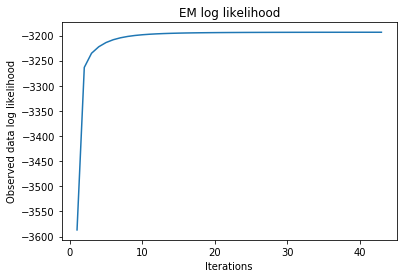

In [16]:
plt.plot([i for i in range(1, len(em.obs_log_lik))], em.obs_log_lik[1:])
plt.xlabel('Iterations')
plt.ylabel('Observed data log likelihood')
plt.title('EM log likelihood')
plt.show()

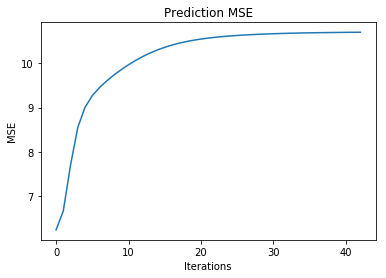

In [17]:
plt.plot([i for i in range(len(em.mse))], em.mse)
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.title('Prediction MSE')
plt.show()

Patient 127


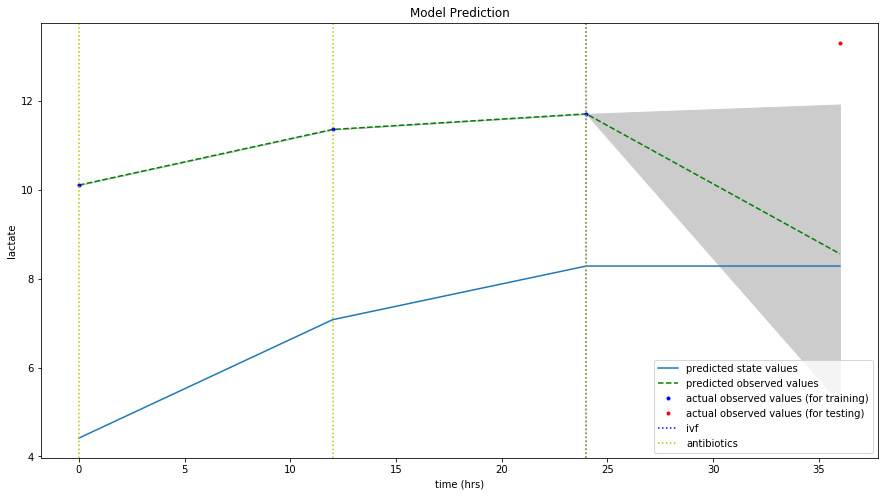

Patient 389


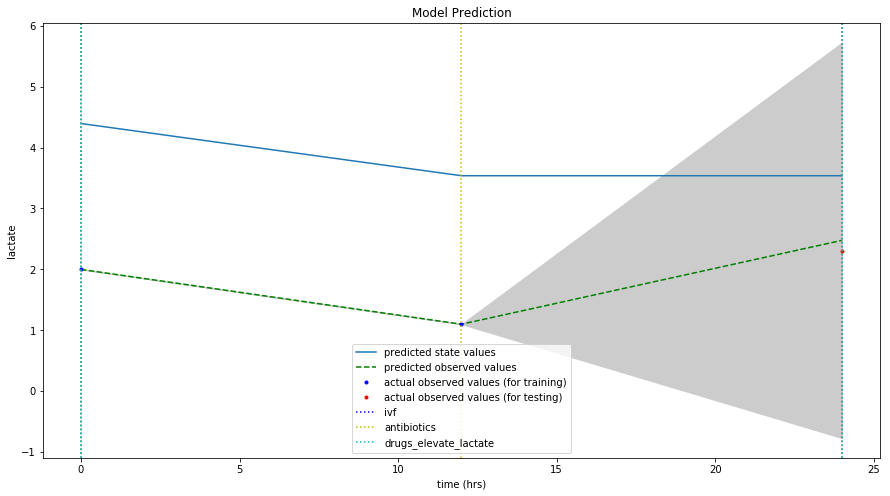

Patient 279


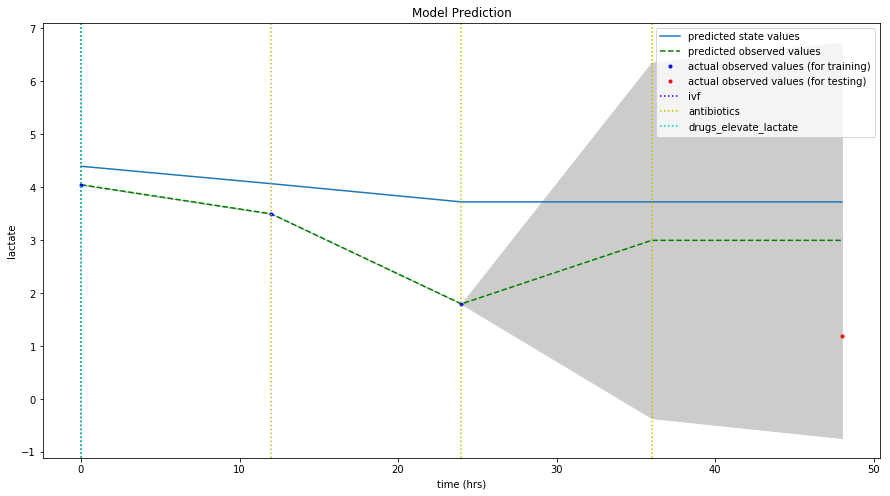

Patient 328


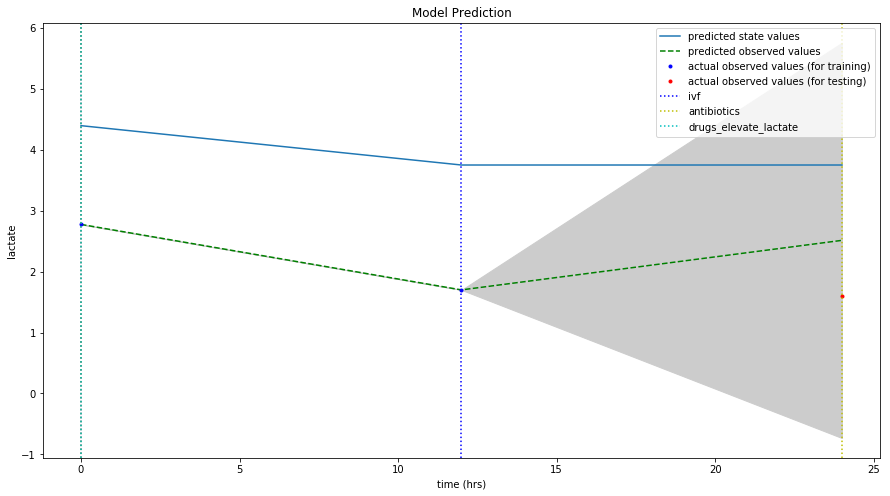

Patient 184


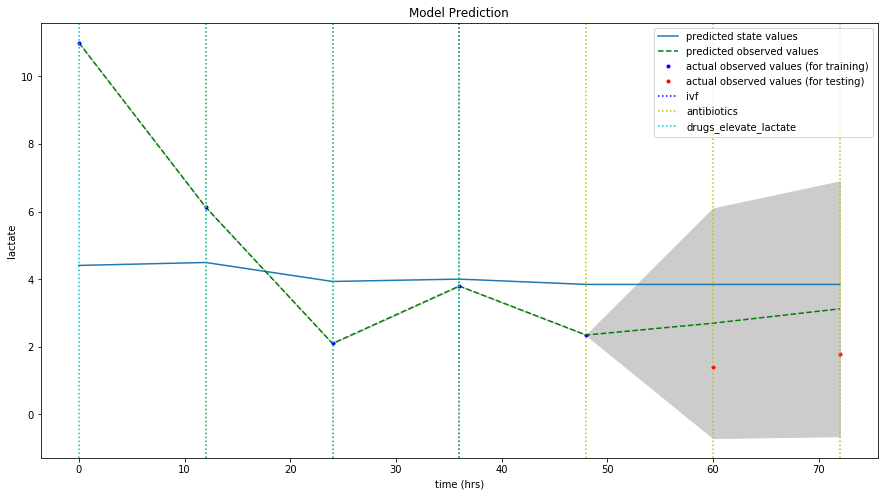

Patient 225


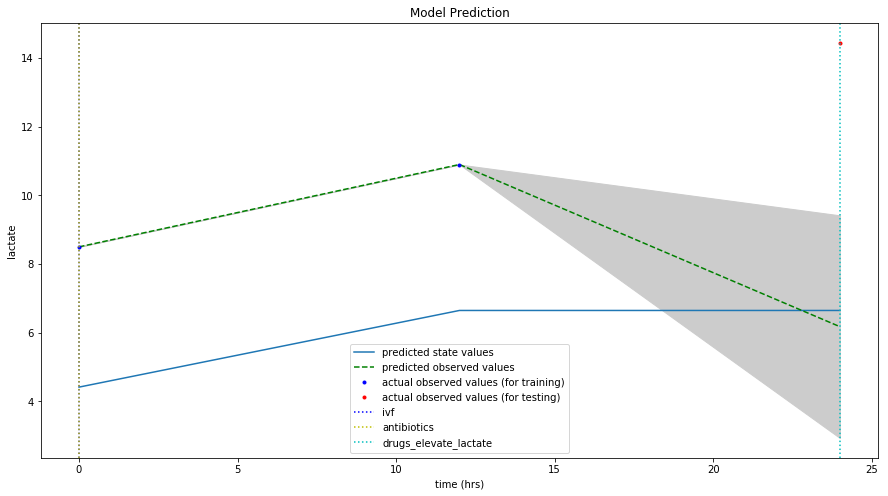

Patient 7


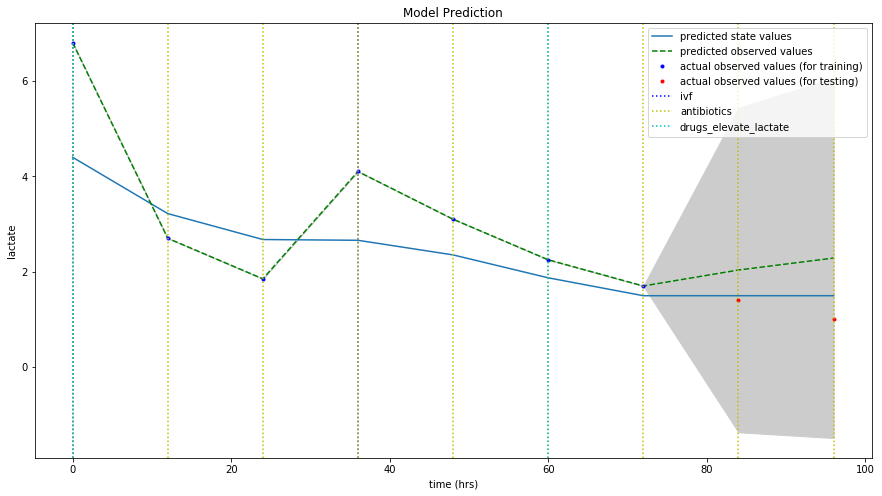

Patient 49


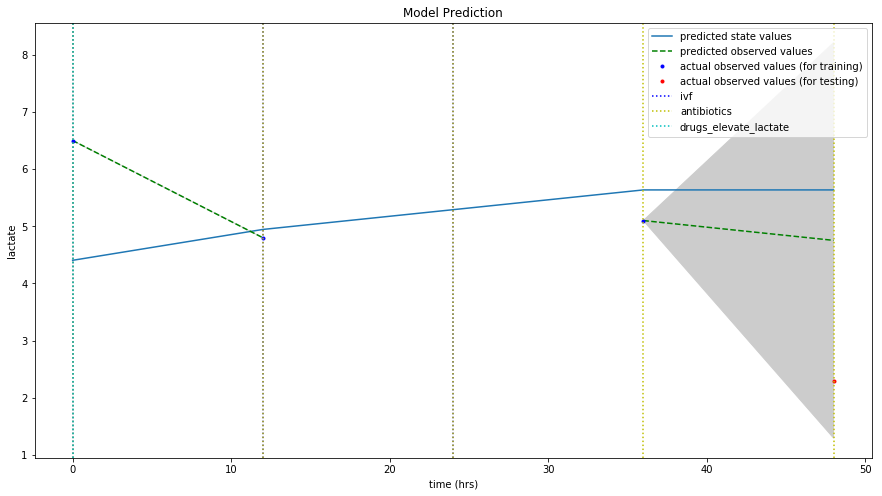

Patient 319


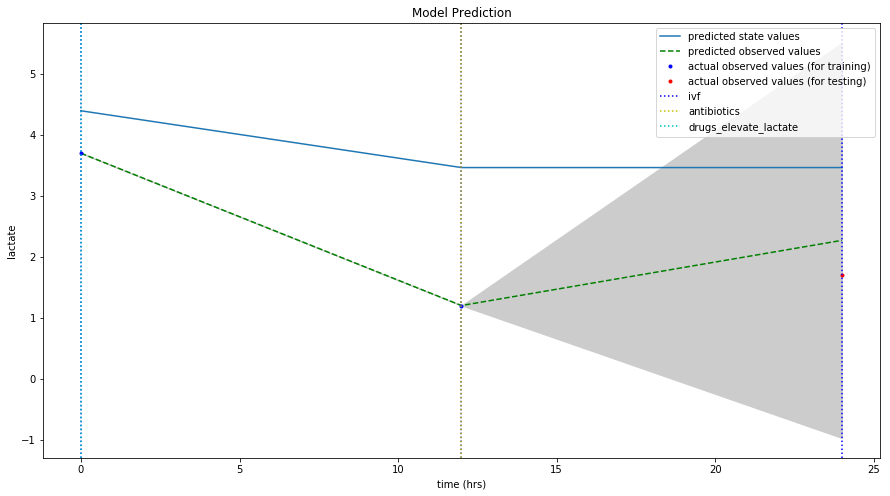

Patient 436


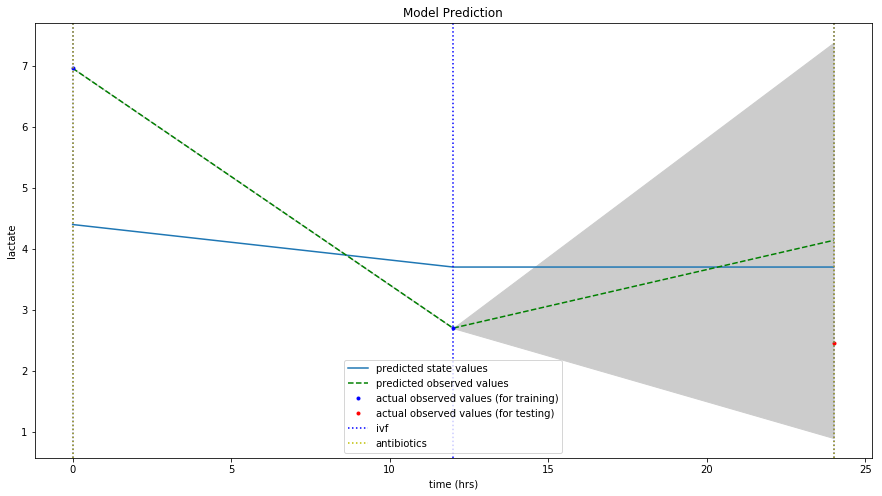

In [18]:
random_patients = np.random.randint(0, em.y.shape[0], 10)
for i in random_patients:
    plot(em, i, 12, signal_name, treatment_types=list(treatment_names.keys()))

### Analysis
Changes
* Only select patients with at least 4 training observations (total of 1821)

On real data
* Issues:
    * treatments coefficients are negative while they should be positive
        * changing initialization doesn't seem to help as model converges in bad local min, and most directions still don't change
    * observation noise is bigger than transition noise
    * run time is long, each iteration takes 4s, M step takes 2.5s, loglik takes 1s
* Reasons:
    * The increasing effects of treatments are not pronouced in the data (see Source Data Analysis)
        * it makes sense that nsaid and aspirin shows small number close to zero since their effects are 50-50.
        * transfusion platelet should be more negative than others, also makes sense.
        * the first number for plasma is a very negative number, but should be close to zero
        * anticoagulant are more negative than platelet, but should be more similar
    * bad noise estimation is expected, specifically underestimated initial state variance and overestimated observational noise 
    
On simulation
* Issues
    * b seems to be harder to identify correctly compared to A (sensitive to initialization)
    * estimated sigma 0 and sigma 2 are very different from the true value (not sensitive to initialization)
        * underestimate sigma 0, overestimate sigma 2
* Reasons
   

2000 iterations (haven't converged, 2nd decimal place different) took 2hrs
Coefficient for nsaid: [-0.05332823  0.01914507 -0.03836663]
Coefficient for transfusion_plasma: [-0.694217   -0.03495779 -0.0522998 ]
Coefficient for transfusion_platelet: [-0.38430565 -0.15892385 -0.31262086]
Coefficient for anticoagulant: [-0.63994745 -0.74545805 -0.5791365 ]
Coefficient for aspirin: [-0.06409683 -0.06972851  0.0302996 ]
Coefficient for chronic kidney failure: -0.2643214568560729
Coefficient for sickle cell: -0.5218307359528491
Coefficient for age: -0.027047728916270067
initial state variance: 0.00020395166620667873
transition noise: 0.14622894241670079
observation noise: 1.127059127544025